In [37]:
#@title ViT Implementaiton

import torch
from torch import nn
import math

class PatchEmbedding(nn.Module):
  """
  Convert the image into patches and then project them into a vector space.
  """
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.img_size = config["img_size"]
    self.patch_size = config["patch_size"]
    self.channels = config["channels"]
    self.hidden_size = config["hidden_size"]
    self.num_patches = (self.img_size // self.patch_size) ** 2
    # Create a projection layer to convert the image into patches
    # The layer projects each patches into a vector (hidden size)
    self.projection = nn.Conv2d(
        self.channels,
        self.hidden_size,
        kernel_size=self.patch_size,
        stride=self.patch_size
    )
    # Creat a learnable [CLS] token
    # The [CLS] token is added to the beginning of the input sequence
    self.cls_token = nn.Parameter(torch.zeros(1, 1, config["hidden_size"]))
    # Create position embeddings for the [CLS] token and the patch embedidngs
    # Add 1 to the sequence length for the [CLS] token
    self.pos_embedding = nn.Parameter(torch.zeros(1, 1 + self.num_patches, config["hidden_size"]))
    self.dropout = nn.Dropout(config["dropout"])

  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.projection(x)
    x = x.flatten(2)
    x = x.transpose(1, 2)

    # Expand the [CLS] token to the batch size
    # (1, 1, h) -> (b, 1, h)
    cls_tokens = self.cls_token.expand(b, -1, -1)
    # Concatenate the [CLS] token to the beginning of the input sequence
    # This results in a sequence length of (num_patches + 1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.pos_embedding
    x = self.dropout(x)
    return x

class Attention(nn.Module):
  """
  Attention Head for MHA
  """
  def __init__(self, hidden_size, attention_head_size, dropout, bias=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.attention_head_size = attention_head_size

    # Create the query, key and value projection layers
    self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
    self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
    self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # Project the input into query, key and value
    # The same input is used to generate the query, key and value
    # So it's called self-attention
    query = self.query(x)
    key = self.key(x)
    value = self.value(x)
    # Calculate attention score
    # softmax(q * k.T / sqrt(head_size)) * v
    attention_scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.attention_head_size)
    attention_probs = torch.softmax(attention_scores, dim=-1)
    attention_probs = self.dropout(attention_probs)
    # Calculate the attention output
    attention_output = torch.matmul(attention_probs, value)
    return (attention_output, attention_probs)

class MultiHeadAttention(nn.Module):
  """
  MHA (Multi-Head Attention)
  """
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.hidden_size = config["hidden_size"]
    self.num_attention_heads = config["num_attention_heads"]
    self.attention_head_size = self.hidden_size // self.num_attention_heads
    # Whether or not to use bias in the query, key, and value porjection layers
    self.qkv_bias = config["qkv_bias"]
    # Create a list of attention heads
    self.heads = nn.ModuleList([])
    for _ in range(self.num_attention_heads):
      self.heads.append(Attention(self.hidden_size, self.attention_head_size, config["dropout"], self.qkv_bias))
    # Create a linear layer to project the attention output back to the hidden size
    self.output_projection = nn.Linear(self.hidden_size, self.hidden_size)
    self.output_dropout = nn.Dropout(config["dropout"])

  def forward(self, x):
    # Calculate the attention output for each attention head
    attention_outputs = []
    for head in self.heads:
      attention_out, _ = head(x)
      attention_outputs.append(attention_out)
    # Concatenate the attention outputs from each attention head
    attention_output = torch.cat(attention_outputs, dim=-1)
    # Project the concatenated attention output back to the hidden size
    attention_output = self.output_projection(attention_output)
    attention_output = self.output_dropout(attention_output)
    return attention_output

class MLP(nn.Module):
  """
  Multi-layer perceptron
  Feedforward
  """
  def __init__(self, config):
    super().__init__()
    self.net = nn.Sequential(
        nn.LayerNorm(config["hidden_size"]),
        nn.Linear(config["hidden_size"], config["intermediate_size"]),
        nn.GELU(),
        nn.Dropout(config["dropout"]),
        nn.Linear(config["intermediate_size"], config["hidden_size"]),
        nn.Dropout(config["dropout"])
    )

  def forward(self, x):
    return self.net(x)

class TransformerBlock(nn.Module):
  """
  Transformer Block
  """
  def __init__(self, config):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(config["hidden_size"])
    self.layernorm2 = nn.LayerNorm(config["hidden_size"])
    self.mha = MultiHeadAttention(config)
    self.mlp = MLP(config)

  def forward(self, x):
    # Self-attention
    attention_output = self.mha(self.layernorm1(x))
    x = x + attention_output
    # Feedforward
    mlp_output = self.mlp(self.layernorm2(x))
    x = x + mlp_output
    return x

class TransformerEncoder(nn.Module):
  """
  Transformer Encoder
  """
  def __init__(self, config):
    super().__init__()
    # Create a list of transformer blocks
    self.blocks = nn.ModuleList([])
    for _ in range(config["num_hidden_layers"]):
      self.blocks.append(TransformerBlock(config))

  def forward(self, x):
    # Calculate the transformer block's output for each block
    for block in self.blocks:
      x = block(x)

    return x

class ViT(nn.Module):
  """
  ViT model and classification
  """
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.img_size = config["img_size"]
    self.hidden_size = config["hidden_size"]
    self.num_classes = config["num_classes"]
    # Create the embedding module
    self.embedding = PatchEmbedding(config)
    # Create the transformer encoder module
    self.encoder = TransformerEncoder(config)
    # Create a linear layer to project the encoder's output to the number of classes
    self.classifier = nn.Linear(config["hidden_size"], config["num_classes"])
    # Initialize the weights
    self.apply(self._init_weights)

  def forward(self, x):
    # Calculate the embedding output
    embedding_output = self.embedding(x)
    # Calculate the encoder's output
    encoder_output = self.encoder(embedding_output)
    # Calculate the logits take the [CLS] token's output as features for classification
    logits = self.classifier(encoder_output[:, 0])

    return logits

  def _init_weights(self, module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
      module.weight.data.normal_(mean=0.0, std=0.02)
      if module.bias is not None:
        module.bias.data.zero_()

In [38]:
#@title data preparation

import torch
import torchvision
import torchvision.transforms as transforms

def data_preparation(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
  train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((32, 32)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.33333333333333), interpolation=2),
      transforms.Normalize((0.5 ,0.5, 0.5), (0.5, 0.5, 0.5))])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

  test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((32, 32)),
      transforms.Normalize((0.5 ,0.5, 0.5), (0.5, 0.5, 0.5))])

  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)

  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  return train_loader, test_loader, classes

In [39]:
#@title Utils

import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)

def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViT(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

Epoch: 1, Train loss: 1.9066, Test loss: 1.6767, Accuracy: 0.3734
Epoch: 2, Train loss: 1.6298, Test loss: 1.5406, Accuracy: 0.4327
Epoch: 3, Train loss: 1.5056, Test loss: 1.4540, Accuracy: 0.4688
Epoch: 4, Train loss: 1.4357, Test loss: 1.4517, Accuracy: 0.4677
Epoch: 5, Train loss: 1.3781, Test loss: 1.3367, Accuracy: 0.5157
Epoch: 6, Train loss: 1.3453, Test loss: 1.3261, Accuracy: 0.5049
Epoch: 7, Train loss: 1.3228, Test loss: 1.3941, Accuracy: 0.5000
Epoch: 8, Train loss: 1.2944, Test loss: 1.2939, Accuracy: 0.5370
Epoch: 9, Train loss: 1.2778, Test loss: 1.3069, Accuracy: 0.5327
Epoch: 10, Train loss: 1.2617, Test loss: 1.2531, Accuracy: 0.5504


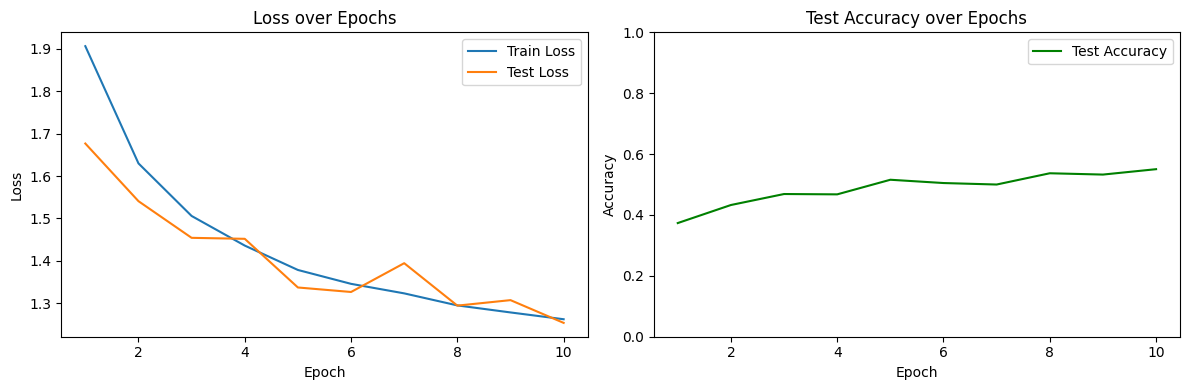

In [41]:
#@title Train ViT

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 10 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "dropout": 0.0,
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "img_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['img_size'] % config['patch_size'] == 0

class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images), labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

def plot_metrics(train_losses, test_losses, accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Train vs Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every

    # Load the CIFAR10 dataset
    trainloader, testloader, _ = data_preparation(batch_size=batch_size)

    # Create the model, optimizer, loss function and trainer
    model = ViT(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)

    # Train
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)

    # Plot metrics after training
    _, _, train_losses, test_losses, accuracies = load_experiment(exp_name)
    plot_metrics(train_losses, test_losses, accuracies)

if __name__ == '__main__':
    main()
